# Week 5-2: The social effects of using machine learning for lending decisions

This notebook uses about a 10% sample of the [Lending Club data set](https://www.kaggle.com/wendykan/lending-club-loan-data) to examine the results of improved default prediction on who gets a loan and who doesn't. 

This analysis is inspired by the paper [Predictably Unequal? The Effects of Machine Learning on Credit Markets](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3072038) by Fuster et al.

For more code that deals with machine learning on this data set, see [Predicting Loan Repayment](https://towardsdatascience.com/predicting-loan-repayment-5df4e0023e92).

This is ~100k row subset of the ~900k records in the original data set. The subset over-samples defaulters enormously, so that repaid vs. defaulted is about 50/50. In the original data it's very much smaller, about 80:20. The preprocessing script does this intentionally, to make the numbers in this example easier to understand. As a side effect, this skews the income distributions because defaulters (who were previously granted a loan, if they're in this data set!) will have different characteristics from non-defaulters, or defaulters who were denied a loan. Another unrealistic thing is that a real loan issuer has some key information that isn't publicly available for privacy reasons, like FICO credit score. 

So **don't take this as reasearch on what the effect of machine learning on loan decisions will actually be.** This document is a learning tool, meant to demonstrate some ways that question could be explored. 

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn import metrics
%matplotlib inline

In [3]:
# Our data subset is all the "charged off" or "defaulted" rows in the original, plus 1/20 the "fully paid"
# In any case, it's concluded loans only, nothing that's still being repaid.
loans = pd.read_csv('loan-subset.csv')
loans.head()

/Users/km/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1064687,1298717,9000.0,9000.0,9000.0,36 months,13.49,305.38,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1069057,1303503,10000.0,10000.0,10000.0,36 months,10.65,325.74,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# how many rows?
len(loans)

98054

In [4]:
# What are the columns? For the column descriptions, see LCDataDictionary.xlsx
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [5]:
# Let's look at value counts for a few fields, to get a sense of what this data is
loans.loan_status.value_counts()

Fully Paid     51587
Charged Off    45248
Default         1219
Name: loan_status, dtype: int64

In [6]:
# What do people get loans for?
loans.purpose.value_counts()

debt_consolidation    58233
credit_card           18661
other                  5785
home_improvement       5454
small_business         2231
major_purchase         2209
car                    1305
medical                1163
moving                  823
wedding                 705
house                   626
vacation                618
educational             131
renewable_energy        110
Name: purpose, dtype: int64

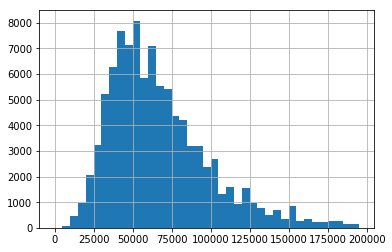

In [7]:
# What does the distribution of income look like?
income_bins=list(range(0,200000,5000))
loans.annual_inc.hist(bins=income_bins)

## 1. A simple classifier
Logisitic regression on a handful of features to try to predict who will fall behind on payments.

We'll generate features from the following columns

- purpose: The purpose of the loan such as: credit_card, debt_consolidation, etc.
- installment: The monthly payment on the loan
- annual_inc: the annual income of the borrower.
- dti: The debt-to-income ratio of the borrower, excluding this loan
- pub_rec: The borrower’s number of derogatory public records.

And the target variable, that we're trying to predict, is:
- loan_status: Fully Paid, Charged Off, or Default

In [8]:
# Encode everything into a feature matrix
features = pd.concat(
    [
        loans.annual_inc/1000, # count in 1000s of dollars, to make the coefficient more easily interpretable
        loans.dti,
        loans.installment,
        loans.pub_rec,
        pd.get_dummies(loans.purpose, prefix='purpose'),
    ],
    axis=1)

# Code the target variable as True if we are predicting that this loan gets repaid in full
target = loans.loan_status == 'Fully Paid'

features.head()

,annual_inc,dti,installment,pub_rec,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,30.0,1.00,59.83,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40.0,5.55,152.39,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,15.0,18.08,121.45,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,30.0,10.08,305.38,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,100.0,7.06,325.74,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [9]:
# Your basic logistic regression
lr = LogisticRegression()
lr.fit(features.values,target.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
# Examine regression coefficients
coeffs = pd.DataFrame(np.exp(lr.coef_), columns=features.columns)
coeffs

,annual_inc,dti,installment,pub_rec,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,1.0069,0.96986,0.999012,0.928943,1.505477,1.400082,1.144862,1.024311,1.168251,1.058983,1.241957,0.850134,0.754301,0.833169,0.964637,0.52969,1.040044,1.464149


In [11]:
# Let's see how well this classifier did
pred_repaid = lr.predict(features.values)
actual_repaid = target.values
metrics.accuracy_score(pred_repaid, actual_repaid)

0.5922144940542966

In [12]:
cm = pd.crosstab(pred_repaid, actual_repaid, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,23423,16941
True,23044,34646


Our interest here is the people who were predicted repay the loan, but actually didn't. These are the false positives, and there are a lot of them in this data set (because this data set is artificially enriched so that about half are defaulters.) On the other hand, the false negatives represent people who we guessed would default, but repaid.

In [13]:
fp = cm[False][True]  # column, row
fp

23044

In [14]:
fn = cm[True][False]
fn

16941

Who are these people? We we get an idea by looking at their relative income distribution. First, here's everybody:

69.91291217910539

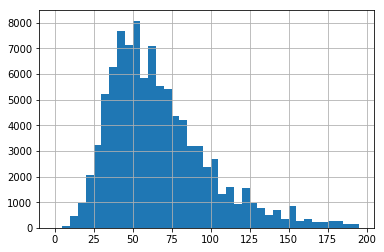

In [15]:
income_bins=list(range(0,200,5))
features.annual_inc.hist(bins=income_bins)
features.annual_inc.mean()

And here's the income of just the false positives:

74.704691478475965

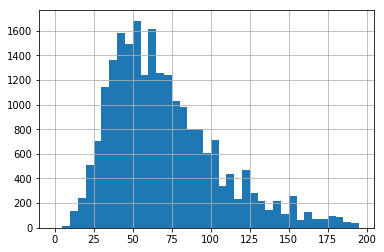

In [16]:
fp_loans = features[~actual_repaid & pred_repaid]
fp_loans.annual_inc.hist(bins=income_bins)
fp_loans.annual_inc.mean()

The false positives have a higher income than the average, \$75,000 vs \$70,000. This makes sense as these are people who we thought would repay, and the model increases its odds of repayment by 0.5% for every thousand dollars of income. This adds up, as you can see in the high income of those predicted to repay:

79.101337028254463

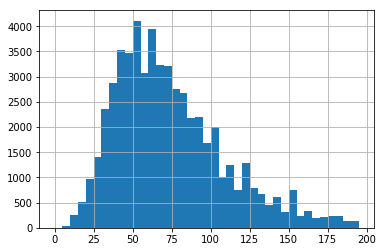

In [28]:
pred_repaid_loans = features[pred_repaid]
pred_repaid_loans.annual_inc.hist(bins=income_bins)
pred_repaid_loans.annual_inc.mean()

## 2. A more accurate classifier

Let's add more features and use a better classifier to see if we can better predict who will pay off their loans. This is what many lending companies are doing right now.

The features we'll add:
- loan_amnt: how much was loaned
- int_rate: The interest rate of the loan 
- grade: Lending Club's internal loan quality grade
- home_ownership: RENT, OWN, MORTGAGE, OTHER
- earliest_cr_line: The month the borrower's earliest reported credit line was opened
- emp_length: employment length in years


In [18]:
# To clean up this column, we'll just extract the year using a regex
loans.earliest_cr_line.head()

0    Apr-1999
1    Apr-2004
2    Sep-2004
3    Apr-2004
4    May-1991
Name: earliest_cr_line, dtype: object

In [19]:
emp_dict = {
     'n/a' : 0,
     '< 1 year' : 0.5,
     ' < 1 year' : 0.5,  # look, dirty data!
     '1 year' : 1,
     '2 years' : 2,
     '3 years' : 3,
     '4 years' : 4,
     '5 years' : 5,
     '6 years' : 6,
     '7 years' : 7,
     '8 years' : 8,
     '9 years' : 9,
     '10+ years' : 10
    }


features2 = pd.concat(
    [
        features,
        loans.loan_amnt,
        loans.int_rate,
        pd.get_dummies(loans.grade, prefix='grade'),
        pd.get_dummies(loans.home_ownership, prefix='home'),
        loans.emp_length.replace(emp_dict, inplace=True),
        loans.earliest_cr_line.str.extract('(\d\d\d\d)', expand=False).astype(int)
    ],
    axis=1)


In [20]:
lr2 = LogisticRegression()
lr2.fit(features2.values, actual_repaid)
pred_repaid2 = lr2.predict(features2.values)
metrics.accuracy_score(pred_repaid2, actual_repaid)

0.64507312297305563

In [21]:
metrics.accuracy_score(pred_repaid2, actual_repaid) - metrics.accuracy_score(pred_repaid, actual_repaid)

0.052858628918759032

Well, we did it. We got a 5.3% accuracy increase from our big data efforts. In real life the impact of using big data could substantial because it's large, percentage-wise, or because the lender has a large number of customers so small changes affect many people.

The confusion matrix shows where the improved accuracy comes from:

In [22]:
cm2 = pd.crosstab(pred_repaid2, actual_repaid, rownames=['guessed'], colnames=['actual'])
cm2

actual,False,True
guessed,,
False,28367,16702
True,18100,34885


In [23]:
# Change in false positive rate
fp2 = cm2[False][True]  # column, row
fp2 - fp

-4944

In [24]:
# Change in false positive rate
fn2 = cm2[True][False]  # column, row
fn2 - fn

-239

This classifer reduces the number of both false negatives and false positives. False negatives are people who repaid their loan, when the old model said they would not, so they have new access to credit that they will successfully repay. On the other hand, a reduction in false positives means we are now denying credit to people who would have gotten it before.

Who are the people who we didn't think would repay, but now believe they will?


In [25]:
newly_eligible = features[~pred_repaid & pred_repaid2]
len(newly_eligible)

12468

58.841178647738211

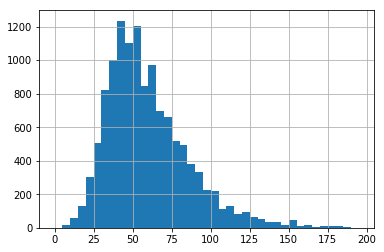

In [26]:
newly_eligible.annual_inc.hist(bins=income_bins)
newly_eligible.annual_inc.mean()

In this case the new classifier admitted a bunch of people who are below our average income (of \$70K), which is a probably a socially desirable outcome -- at least for the ones who are able to repay. How many of the newly admitted will default?

In [27]:
(~pred_repaid & pred_repaid2 & ~actual_repaid).sum()

5046

and whether *that* is socially desirable or not depends on what happens when someone defaults, which is a complicated question of law, finance, and power. There's only so far that technical analysis of machine learning can go before it hits the interface with the real world, where everything happens to real people.